<a href="https://colab.research.google.com/github/wiseman-s/mpesa-sms-analyzer/blob/main/mpesa-sms-analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = {
    "date": [
        "2025-08-20 12:34:00",
        "2025-08-20 14:15:00",
        "2025-08-21 09:00:00",
        "2025-08-21 11:40:00",
        "2025-08-21 15:20:00",
        "2025-08-22 08:50:00",
        "2025-08-22 09:05:00",
        "2025-08-22 17:45:00"
    ],
    "text": [
        "Ksh500.00 sent to 0722000000 on 20/08/25 at 12:34 PM. M-PESA balance is Ksh1,230.00.",
        "PETER NJOROGE NJOROGE has sent KShs. 900.0 to your MPESA. The MPESA receipt number is TEH14R62BV and transaction reference is EQAA120C60CE3B9.",
        "You have received Ksh1,000.00 from JOHN DOE on 21/08/25 at 9:00 AM. New M-PESA balance is Ksh2,230.00.",
        "Paid Ksh200.00 to KPLC via Paybill 888880 on 21/08/25 at 11:40 AM. New balance Ksh2,030.00.",
        "Paid Ksh1500.00 to EQUITY BANK via Paybill 247247 on 21/08/25 at 3:20 PM. Transaction cost Ksh23.00.",
        "Withdrawn Ksh1,000.00 from agent 07XXXX. Transaction successful. New M-PESA balance is Ksh1,030.00.",
        "Airtime top-up of Ksh50.00 for 07XXXX successful. New M-PESA balance is Ksh980.00.",
        "Ksh3000.00 received from COMPANY LTD on 22/08/25 at 5:45 PM. New balance is Ksh3,980.00."
    ]
}

df = pd.DataFrame(data)
df.to_csv("mpesa_sms.csv", index=False)
print("mpesa_sms.csv created!")

mpesa_sms.csv created!


In [2]:
import pandas as pd

# Load the file you just created
df = pd.read_csv("mpesa_sms.csv")

# Show first rows
df.head()

,date,text
0,2025-08-20 12:34:00,Ksh500.00 sent to 0722000000 on 20/08/25 at 12...
1,2025-08-20 14:15:00,PETER NJOROGE NJOROGE has sent KShs. 900.0 to ...
2,2025-08-21 09:00:00,"You have received Ksh1,000.00 from JOHN DOE on..."
3,2025-08-21 11:40:00,Paid Ksh200.00 to KPLC via Paybill 888880 on 2...
4,2025-08-21 15:20:00,Paid Ksh1500.00 to EQUITY BANK via Paybill 247...


In [3]:
import re

def parse_sms(text):
    result = {
        "type": None,   # e.g. Sent, Received, Paybill, Withdraw, Airtime
        "amount": None,
        "balance": None,
        "paybill": None,
        "sender": None
    }

    # Amount pattern (Ksh / KShs / Kshs etc.)
    amount_match = re.search(r'Kshs?\.?\s?([\d,]+\.?\d*)', text, re.IGNORECASE)
    if amount_match:
        result["amount"] = float(amount_match.group(1).replace(",", ""))

    # Balance
    balance_match = re.search(r'balance (?:is )?Kshs?\.?\s?([\d,]+\.?\d*)', text, re.IGNORECASE)
    if balance_match:
        result["balance"] = float(balance_match.group(1).replace(",", ""))

    # Detect transaction type
    if "sent to" in text.lower():
        result["type"] = "Sent"
    elif "has sent" in text.lower() or "received" in text.lower():
        result["type"] = "Received"
    elif "paybill" in text.lower():
        result["type"] = "Paybill"
        paybill_match = re.search(r'Paybill\s+(\d+)', text)
        if paybill_match:
            result["paybill"] = paybill_match.group(1)
    elif "withdrawn" in text.lower():
        result["type"] = "Withdraw"
    elif "airtime" in text.lower():
        result["type"] = "Airtime"

    # Sender name
    sender_match = re.search(r'([A-Z]+\s+[A-Z]+\s+[A-Z]+) has sent', text)
    if sender_match:
        result["sender"] = sender_match.group(1)

    return result

# Apply parser
parsed = df["text"].apply(parse_sms)
parsed_df = pd.DataFrame(parsed.tolist())

# Combine with original
final_df = pd.concat([df, parsed_df], axis=1)
final_df.head()

,date,text,type,amount,balance,paybill,sender
0,2025-08-20 12:34:00,Ksh500.00 sent to 0722000000 on 20/08/25 at 12...,Sent,500.0,1230.0,None,None
1,2025-08-20 14:15:00,PETER NJOROGE NJOROGE has sent KShs. 900.0 to ...,Received,900.0,NaN,None,PETER NJOROGE NJOROGE
2,2025-08-21 09:00:00,"You have received Ksh1,000.00 from JOHN DOE on...",Received,1000.0,2230.0,None,None
3,2025-08-21 11:40:00,Paid Ksh200.00 to KPLC via Paybill 888880 on 2...,Paybill,200.0,2030.0,888880,None
4,2025-08-21 15:20:00,Paid Ksh1500.00 to EQUITY BANK via Paybill 247...,Paybill,1500.0,NaN,247247,None


In [4]:
# Group by transaction type
summary = final_df.groupby("type")["amount"].sum().reset_index()

print("📊 Transaction Summary")
print(summary)

# Total sent
total_sent = final_df.loc[final_df["type"] == "Sent", "amount"].sum()
# Total received
total_received = final_df.loc[final_df["type"] == "Received", "amount"].sum()
# Total paybill
total_paybill = final_df.loc[final_df["type"] == "Paybill", "amount"].sum()

print("\n➡️ Total Sent: ", total_sent)
print("➡️ Total Received: ", total_received)
print("➡️ Total Paybill Payments: ", total_paybill)

📊 Transaction Summary
       type  amount
0   Airtime    50.0
1   Paybill  1700.0
2  Received  4900.0
3      Sent   500.0
4  Withdraw  1000.0

➡️ Total Sent:  500.0
➡️ Total Received:  4900.0
➡️ Total Paybill Payments:  1700.0


📊 M-PESA TRANSACTION DASHBOARD 📊

Summary of Transactions by Type

       type  amount
0   Airtime    50.0
1   Paybill  1700.0
2  Received  4900.0
3      Sent   500.0
4  Withdraw  1000.0


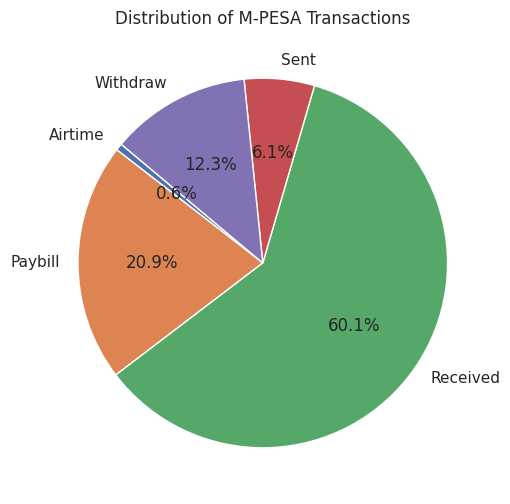

/tmp/ipython-input-3117546007.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="type", y="amount", data=summary, palette="Blues_d")


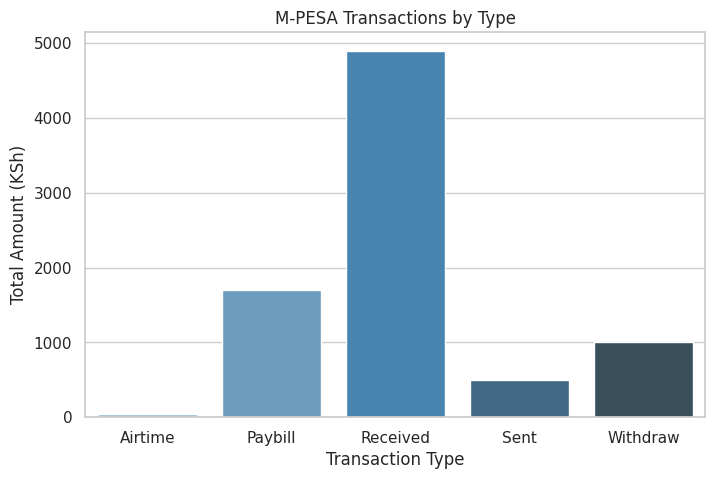

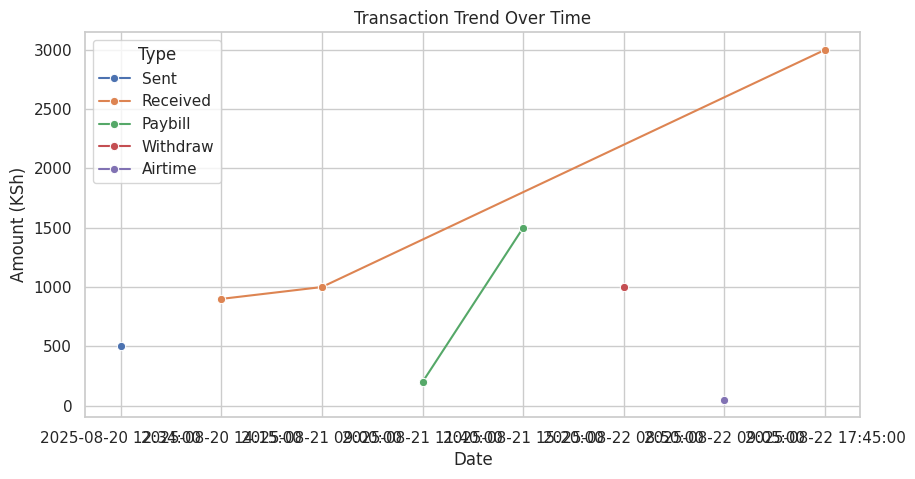

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set clean style
sns.set(style="whitegrid")

# 1. Summary Table
print("📊 M-PESA TRANSACTION DASHBOARD 📊\n")
print("Summary of Transactions by Type\n")
print(summary)

# 2. Pie Chart - Distribution
plt.figure(figsize=(6,6))
plt.pie(summary["amount"], labels=summary["type"], autopct="%1.1f%%", startangle=140)
plt.title("Distribution of M-PESA Transactions")
plt.show()

# 3. Bar Chart - Amount per Type
plt.figure(figsize=(8,5))
sns.barplot(x="type", y="amount", data=summary, palette="Blues_d")
plt.title("M-PESA Transactions by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Total Amount (KSh)")
plt.show()

# 4. Trend Over Time
plt.figure(figsize=(10,5))
sns.lineplot(x="date", y="amount", data=final_df, hue="type", marker="o")
plt.title("Transaction Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Amount (KSh)")
plt.legend(title="Type")
plt.show()

In [6]:
# Export transactions + summary to Excel
with pd.ExcelWriter("mpesa_report.xlsx") as writer:
    final_df.to_excel(writer, sheet_name="Transactions", index=False)
    summary.to_excel(writer, sheet_name="Summary", index=False)

print("✅ Excel report saved as mpesa_report.xlsx")

✅ Excel report saved as mpesa_report.xlsx


In [7]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# Create PDF
pdf_file = "mpesa_report.pdf"
c = canvas.Canvas(pdf_file, pagesize=A4)

c.setFont("Helvetica-Bold", 16)
c.drawString(100, 800, "M-PESA Transactions Report")

c.setFont("Helvetica", 12)
c.drawString(100, 770, "Summary of Transactions:")

y = 750
for i, row in summary.iterrows():
    line = f"{row['type']}: KSh {row['amount']}"
    c.drawString(120, y, line)
    y -= 20

c.save()
print("✅ PDF report saved as mpesa_report.pdf")

ModuleNotFoundError: No module named 'reportlab'

In [8]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00


In [9]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# Create PDF
pdf_file = "mpesa_report.pdf"
c = canvas.Canvas(pdf_file, pagesize=A4)

c.setFont("Helvetica-Bold", 16)
c.drawString(100, 800, "M-PESA Transactions Report")

c.setFont("Helvetica", 12)
c.drawString(100, 770, "Summary of Transactions:")

y = 750
for i, row in summary.iterrows():
    line = f"{row['type']}: KSh {row['amount']}"
    c.drawString(120, y, line)
    y -= 20

c.save()
print("✅ PDF report saved as mpesa_report.pdf")

✅ PDF report saved as mpesa_report.pdf


In [10]:
from google.colab import files
files.download("mpesa_report.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import matplotlib.pyplot as plt

# Pie chart for transaction types
plt.figure(figsize=(5,5))
plt.pie(summary["amount"], labels=summary["type"], autopct='%1.1f%%', startangle=90)
plt.title("M-PESA Transactions Breakdown")
plt.savefig("pie_chart.png")
plt.close()

# Bar chart for amounts
plt.figure(figsize=(6,4))
plt.bar(summary["type"], summary["amount"])
plt.title("M-PESA Transactions by Type")
plt.ylabel("Amount (KSh)")
plt.savefig("bar_chart.png")
plt.close()

print("✅ Charts saved as images (pie_chart.png, bar_chart.png)")

✅ Charts saved as images (pie_chart.png, bar_chart.png)


In [12]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.platypus import Image

pdf_file = "mpesa_report_dashboard.pdf"
c = canvas.Canvas(pdf_file, pagesize=A4)

# Title
c.setFont("Helvetica-Bold", 16)
c.drawString(100, 800, "M-PESA Transactions Report")

# Summary text
c.setFont("Helvetica", 12)
c.drawString(100, 770, "Summary of Transactions:")

y = 750
for i, row in summary.iterrows():
    line = f"{row['type']}: KSh {row['amount']}"
    c.drawString(120, y, line)
    y -= 20

# Add Pie Chart
c.drawImage("pie_chart.png", 70, 400, width=400, height=300)

# Add Bar Chart
c.drawImage("bar_chart.png", 70, 100, width=400, height=250)

c.save()
print("✅ PDF dashboard saved as mpesa_report_dashboard.pdf")

✅ PDF dashboard saved as mpesa_report_dashboard.pdf


In [13]:
from google.colab import files
files.download("mpesa_report_dashboard.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Group by date
timeline = df.groupby("date")["amount"].sum().reset_index()

# Line chart (Transactions over time)
plt.figure(figsize=(7,4))
plt.plot(timeline["date"], timeline["amount"], marker="o")
plt.title("M-PESA Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Total Amount (KSh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("timeline_chart.png")
plt.close()

print("✅ Timeline chart saved as timeline_chart.png")

KeyError: 'Column not found: amount'

In [15]:
# Group by date
timeline = df.groupby("date")["amount"].sum().reset_index()

# Line chart (Transactions over time)
plt.figure(figsize=(7,4))
plt.plot(timeline["date"], timeline["amount"], marker="o")
plt.title("M-PESA Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Total Amount (KSh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("timeline_chart.png")
plt.close()

print("✅ Timeline chart saved as timeline_chart.png")

KeyError: 'Column not found: amount'

In [17]:
 df.head()

,date,text
0,2025-08-20 12:34:00,Ksh500.00 sent to 0722000000 on 20/08/25 at 12...
1,2025-08-20 14:15:00,PETER NJOROGE NJOROGE has sent KShs. 900.0 to ...
2,2025-08-21 09:00:00,"You have received Ksh1,000.00 from JOHN DOE on..."
3,2025-08-21 11:40:00,Paid Ksh200.00 to KPLC via Paybill 888880 on 2...
4,2025-08-21 15:20:00,Paid Ksh1500.00 to EQUITY BANK via Paybill 247...


In [18]:
df.columns

Index(['date', 'text'], dtype='object')

In [19]:
['date', 'name', 'amount_transacted', 'transaction_type']

['date', 'name', 'amount_transacted', 'transaction_type']

In [20]:
timeline = df.groupby("date")["amount_transacted"].sum().reset_index()

KeyError: 'Column not found: amount_transacted'

In [21]:
df.columns.tolist()

['date', 'text']

In [22]:
df.columns = df.columns.str.strip().str.lower()

In [23]:
timeline = df.groupby("date")["amount"].sum().reset_index()

KeyError: 'Column not found: amount'

In [24]:
# Standardize column names: lowercase + remove extra spaces
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [25]:
timeline = df.groupby("date")["amount"].sum().reset_index()

KeyError: 'Column not found: amount'

In [26]:
print(df.columns.tolist())

['date', 'text']


In [29]:
print(df.columns.tolist())

['date', 'text']


In [27]:
df.head()

,date,text
0,2025-08-20 12:34:00,Ksh500.00 sent to 0722000000 on 20/08/25 at 12...
1,2025-08-20 14:15:00,PETER NJOROGE NJOROGE has sent KShs. 900.0 to ...
2,2025-08-21 09:00:00,"You have received Ksh1,000.00 from JOHN DOE on..."
3,2025-08-21 11:40:00,Paid Ksh200.00 to KPLC via Paybill 888880 on 2...
4,2025-08-21 15:20:00,Paid Ksh1500.00 to EQUITY BANK via Paybill 247...


In [28]:
timeline = df.groupby("date")["<actual_column_name_here>"].sum().reset_index()

KeyError: 'Column not found: <actual_column_name_here>'